In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv') 
# data = pd.read_csv('C:\\Users\\Priyam\\Documents\\ML Assignments\\MNIST\\train\\train.csv')

data = pd.read_csv('train.csv') # /kaggle/input/digit-recognizer/train.csv

In [2]:
data.head(8)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into training and test sets

data_train = data[0:1000].T
Y_train = data_train[0].astype(int)
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

data_test = data[1000:m].T
Y_test = data_test[0].astype(int)
X_test = data_test[1:n]
X_test = X_test / 255.

In [27]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    k0 = np.random.rand(1,1)
    k1 = np.random.rand(1,1)
    return W1, b1, W2, b2, k0, k1

# Activation function for hidden layer
def activation_fn(Z, k0, k1): 
    return k0 + k1*Z

# Derivative of activation function for hidden layer
def activation_fn_deriv(Z, k0, k1):
    return k1

# Activation function for output layer
def softmax(Z): 
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, int(Y.max()) + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y
    
def forward_prop(W1, b1, W2, b2, k0, k1, X):
    Z1 = W1.dot(X) + b1
    A1 = activation_fn(Z1, k0, k1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, k0, k1, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * activation_fn_deriv(Z1, k0, k1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    da1 = W2.T.dot(dZ2)
    dk0 = 1 / m * np.sum(da1)
    temp = np.multiply(da1,Z1)
    dk1 = np.mean(temp)
    return dW1, db1, dW2, db2, dk0, dk1

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, k0, k1, dk0, dk1, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2
    k0 = k0 - alpha * dk0
    k1 = k1 - alpha * dk1
    return W1, b1, W2, b2, k0, k1

In [28]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [29]:
def cross_entropy(Y, A2, p):
    row, col = np.shape(A2)
    loss_CE = list()
    for i in range(col):
        pos = np.where(p[:,col-1]==1)
        loss = - p[pos,col-1]*np.log(softmax(A2[:,col-1])[pos])
        loss_CE.append(loss)
    return np.mean(loss_CE)

def gradient_descent(X, Y, X_test, Y_test, alpha, iterations):
    W1, b1, W2, b2, k0, k1 = init_params()
    k0_list = list()
    k1_list = list()
    loss_entropy_train = list()
    loss_entropy_test = list()
    epochs = list()
    
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, k0, k1, X)
        dW1, db1, dW2, db2, dk0, dk1 = backward_prop(Z1, A1, Z2, A2, W1, W2, k0, k1, X, Y)
        W1, b1, W2, b2, k0, k1 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, k0, k1, dk0, dk1, alpha)
        
        epochs.append(i)
        k0_list.append(k0)
        k1_list.append(k1)
        
        true_label = one_hot(Y)
        loss_entropy_train.append(cross_entropy(Y, A2, true_label))
        
        Z1_test, A1_test, Z2_test, A2_test = forward_prop(W1, b1, W2, b2, k0, k1, X_test)
        true_label_test = one_hot(Y_test)
        loss_entropy_test.append(cross_entropy(Y_test, A2_test, true_label_test))
        
        if i % 1000 == 0:            
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
            print("Loss (train): {:.3g} nats".format(loss_entropy_train[i-1]))
            print("Loss (test): {:.3g} nats".format(loss_entropy_test[i-1]))
    return W1, b1, W2, b2, k0, k1, k0_list, k1_list, epochs, loss_entropy_train, loss_entropy_test

In [30]:
W1, b1, W2, b2, k0, k1, k0_list, k1_list, epochs, loss_entropy_train, loss_entropy_test = gradient_descent(X_train, Y_train, X_test, Y_test, 0.10, 2000) # Learning rate alpha = 0.1, total epochs = 2000

Iteration:  0
0.081
Loss (train): 2.41 nats
Loss (test): 2.4 nats
Iteration:  1000
0.836
Loss (train): 1.47 nats
Loss (test): 1.49 nats


In [40]:
print(f'The final values of parameters: k_0 = {k0}, k_1 = {k1}')

The final values of parameters: k_0 = [[0.53145857]], k_1 = [[1.63123416]]


In [35]:
def make_predictions(X, W1, b1, W2, b2, k0, k1):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, k0, k1, X)
    predictions = get_predictions(A2)
    return predictions

In [43]:
# Train data accuracy
train_data_predictions = make_predictions(X_train, W1, b1, W2, b2, k0, k1)
get_accuracy(train_data_predictions, Y_train)

0.929

In [41]:
# Test data accuracy
test_data_predictions = make_predictions(X_test, W1, b1, W2, b2, k0, k1)
get_accuracy(test_data_predictions, Y_test)

0.8138950892857143

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

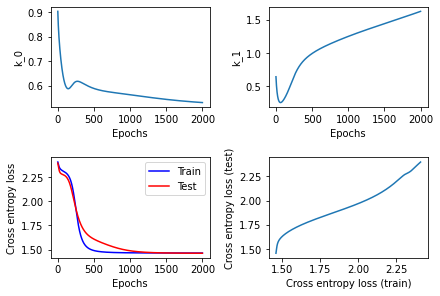

In [44]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
axs[0,0].plot(epochs, np.squeeze(k0_list))
axs[0,0].set(xlabel = 'Epochs', ylabel = 'k_0')
axs[0,1].plot(epochs, np.squeeze(k1_list))
axs[0,1].set(xlabel = 'Epochs', ylabel = 'k_1')
axs[1,0].plot(epochs,loss_entropy_train,'-b',label = 'Train')
axs[1,0].plot(epochs,loss_entropy_test,'-r',label = 'Test')
axs[1,0].legend()
axs[1,0].set(xlabel = 'Epochs', ylabel = 'Cross entropy loss')
axs[1,1].plot(loss_entropy_train,loss_entropy_test)
axs[1,1].set(xlabel = 'Cross entropy loss (train)', ylabel = 'Cross entropy loss (test)')

from google.colab import files
plt.savefig('mnist_fig.jpg')
files.download('mnist_fig.jpg')

In [42]:
from sklearn.metrics import f1_score
f1 = f1_score(Y_test, test_data_predictions,average = 'weighted')
print(f'F1-Score is: {f1}')

F1-Score is: 0.8140924474669023
